### Projet Monte Carlo - ABC for alpha-stable models
## Zakaria BOULIAIRE, Clémence CHEVRIER, Félix DE CHAMPS DE SAINT LEGER, Enzo LOUNES

## 1. Import des modules nécessaires

In [191]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import levy_stable

On fixe la graine pour assurer la reproductibilité des résultats. 

In [192]:
np.random.seed(123)

## Question 1 : Implement the generator for alpha-stable distributions proposed in Appendix B, and explain why it is valid

# 1.1. Echantillonnage de W à partir d'une distribution exponentielle

In [193]:
w = np.random.exponential(scale=1)
print("w =", w)

w = 1.1922721434811057


# 1.2. Echantillonnage de U à partir d'une distribution uniforme

In [194]:
u = np.random.uniform(-np.pi/2, np.pi/2)
print("u =", u)

u = -0.6718630942117153


# 1.3. Appliquer la transformation pour obtenir l'échantillon y_barre

In [195]:
# On définit en premier lieu les S et B pour plus de clarté
def S(alpha, beta): 
    tan_term = np.tan(np.pi * alpha / 2)**2
    result = (1 + beta**2 * tan_term)**(1 / (2 * alpha))
    return result

def B(alpha, beta):
    tan_term = beta * np.tan(np.pi * alpha / 2)
    result = 1 / alpha * np.arctan(tan_term)
    return result

def calculate_y_barre(alpha, beta, u, w):
    if alpha != 1:
        S_alpha_beta = S(alpha, beta)
        B_alpha_beta = B(alpha, beta)
        sin_alpha = np.sin(alpha)
        cos_u = np.cos(u)
        term1 = S_alpha_beta * (sin_alpha * (u + B_alpha_beta))
        term2 = (cos_u) ** (1 / alpha)
        term3 = np.cos(u - alpha * (u + B_alpha_beta)) / w
        term4 = ((1 - alpha) / alpha)
        y_barre = (term1 / term2) * (term3 ** term4)
    else:
        term1 = (np.pi / 2 + beta * u) * np.tan(u)
        term2 = beta * np.log((np.pi / 2) * w * np.cos(u) / (np.pi / 2 + beta * u))
        y_barre = 2 / np.pi * (term1 - term2)
    return y_barre

print(calculate_y_barre(0.6,1,u,w))

0.8207043313879683


# 1.4. On applique une nouvelle transformation pour obtenir y

In [196]:
def transformation(alpha, beta, gamma, delta, u, w):
    y_barre = calculate_y_barre(alpha, beta, u, w)
    y = gamma * y_barre + delta
    return y

print(transformation(0.6,1,1,0,u,w))

0.8207043313879683


In [197]:
alpha = 0.6
beta = 1
gamma = 1
delta = 0

# Nombre d'échantillons
n = 1000

# Génération d'échantillons à partir de la distribution alpha-stable avec SciPy
stable_samples = levy_stable.rvs(alpha, beta, loc=delta, scale=gamma)

# Calculer y_barre avec votre fonction
y = transformation(alpha, beta, gamma, delta, u, w)

# Comparer les résultats avec SciPy
print("Moyenne de y avec votre fonction :", np.mean(y))
print("Moyenne de y avec levy_stable.rvs :", np.mean(stable_samples))

Moyenne de y avec votre fonction : 0.8207043313879683
Moyenne de y avec levy_stable.rvs : 1.0154946934750861


## Question 2 : Explain how you could modify this generator to use RQMC sequences in order to approximate expectations under an alpha-stable distribution. Implement this for a certain function, and compare the resulting RQMC estimates with standard Monte Carlo estimates. (Careful: again, an alpha-stable distribution is typically heavy-tailed, make sure you choose a function whose variance is finite. . . ).

Pour modifier ce générateur pour utiliser des séquences QMC pour approximer les expectations avec un distribution alpha-stable, on peut d abord chosir une sequence RQMC comme celle de Sobol, Halton ou Faure qui sont présentées dans l'article. Nous choisirons Sobol. En effet, ces séquences sont conçues pour être semi-aleatoires, et couvrir l'espace de manière plus optimale. Ensuite, on pourra modifier le générateur de la question 1 pour utiliser les valeurs de la séquence RQMC à la place des valeurs aléatoires précédemment utilisées. Alors, la convergence vers l'estimation de l'esperance sera plus rapide. Ensuite, on compare avec les estimations Monte Carlo standard.

Définition des fonctions de variance finie.

In [198]:
def f1(x):
    return x

def f2(x):
    return np.exp(-x**2)

def f3(x):
    return x**2 + x + 1

def f4(x):
    return np.sin(x)

Codons la partie sur la séquence de Sobol.

In [199]:
def sobol_sequence(n, d):
    from scipy.stats import qmc
    sobol = qmc.Sobol(d)
    points = sobol.random(n)
    return points

print(sobol_sequence(2,3))

[[0.6623526  0.97296369 0.98479684]
 [0.44381175 0.11404391 0.07639793]]


Codons une fonctions pour estimer l'espérance avec Monte Carlo standard. 

In [200]:
def monte_carlo_estimate(f, n, alpha, beta, gamma, delta):
    w = np.random.exponential(scale=1, size=n)
    u = np.random.uniform(-np.pi/2, np.pi/2, size=n)
    y = transformation(alpha, beta, gamma, delta, u, w)
    return np.mean(f(y))

Maintenant, codons la fonction pour estimer l'espérance avec RQMC.

In [201]:

def rqmc_estimate(f, n, alpha, beta, gamma, delta):
    d = 1  # Dimension de la séquence
    points = sobol_sequence(n, d)
    u = np.arccos(2 * points - 1) - np.pi/2  # Transformation pour obtenir u entre -pi/2 et pi/2
    w = -np.log(1 - points)  # Transformation pour obtenir w selon une distribution exponentielle
    y = transformation(alpha, beta, gamma, delta, u, w)
    return np.mean(f(y))

En utilisant le module levy_stable pour les fonctions : 

In [202]:
def monte_carlo_estimate(f, n, alpha, beta, gamma, delta):
    w = np.random.exponential(scale=1, size=n)
    u = np.random.uniform(-np.pi/2, np.pi/2, size=n)
    y = levy_stable.rvs(alpha, beta, loc=delta, scale=gamma,size=n)
    return np.mean(f(y))

def rqmc_estimate(f, n, alpha, beta, gamma, delta):
    d = 1  # Dimension de la séquence
    points = sobol_sequence(n, d)
    u = np.arccos(2 * points - 1) - np.pi/2  # Transformation pour obtenir u entre -pi/2 et pi/2
    w = -np.log(1 - points)  # Transformation pour obtenir w selon une distribution exponentielle
    y = levy_stable.rvs(alpha, beta, loc=delta, scale=gamma,size=n)
    return np.mean(f(y))

In [203]:
alpha = 0.6
beta = 1
gamma = 1
delta = 0

# Nombre d'échantillons
n = 1000

Calculons maintenant les estimations avec Monte Carlo standard et RQMC pour chaque fonction. 

In [204]:
mc_estimate1 = monte_carlo_estimate(f1, n, alpha, beta, gamma, delta)
rqmc_estimate1 = rqmc_estimate(f1, n, alpha, beta, gamma, delta)

mc_estimate2 = monte_carlo_estimate(f2, n, alpha, beta, gamma, delta)
rqmc_estimate2 = rqmc_estimate(f2, n, alpha, beta, gamma, delta)

mc_estimate3 = monte_carlo_estimate(f3, n, alpha, beta, gamma, delta)
rqmc_estimate3 = rqmc_estimate(f3, n, alpha, beta, gamma, delta)

mc_estimate4 = monte_carlo_estimate(f4, n, alpha, beta, gamma, delta)
rqmc_estimate4 = rqmc_estimate(f4, n, alpha, beta, gamma, delta)

print("Monte Carlo Estimate 1:", mc_estimate1)
print("RQMC Estimate 1:", rqmc_estimate1)

print("Monte Carlo Estimate 2:", mc_estimate2)
print("RQMC Estimate 2:", rqmc_estimate2)

print("Monte Carlo Estimate 3:", mc_estimate3)
print("RQMC Estimate 3:", rqmc_estimate3)

print("Monte Carlo Estimate 4:", mc_estimate4)
print("RQMC Estimate 4:", rqmc_estimate4)


Monte Carlo Estimate 1: 153.07801023463347
RQMC Estimate 1: 2584.2106588044426
Monte Carlo Estimate 2: 0.17504407070239125
RQMC Estimate 2: 0.17335590702733414
Monte Carlo Estimate 3: 875773.4066037781
RQMC Estimate 3: 902607.3616285404
Monte Carlo Estimate 4: 0.37532666289167954
RQMC Estimate 4: 0.3897585238792834


C:\Users\cleme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Nous obtenons les graphiques suivants : 

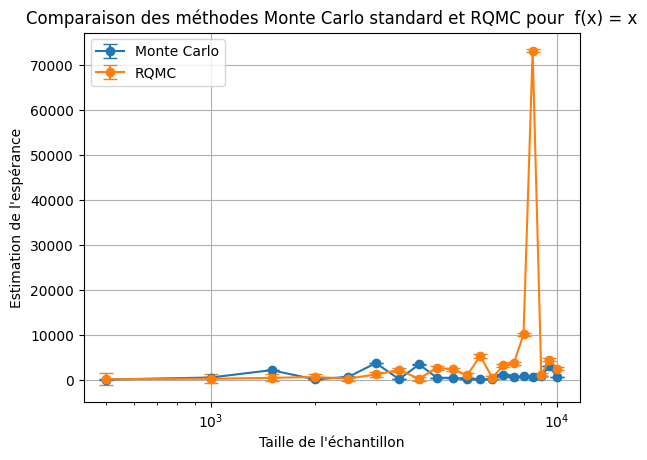

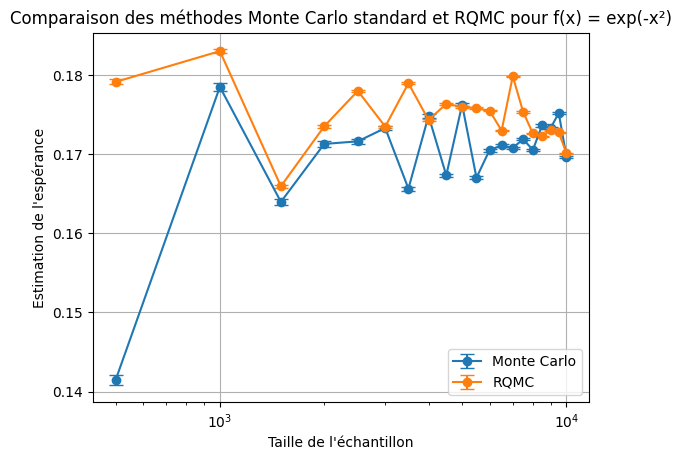

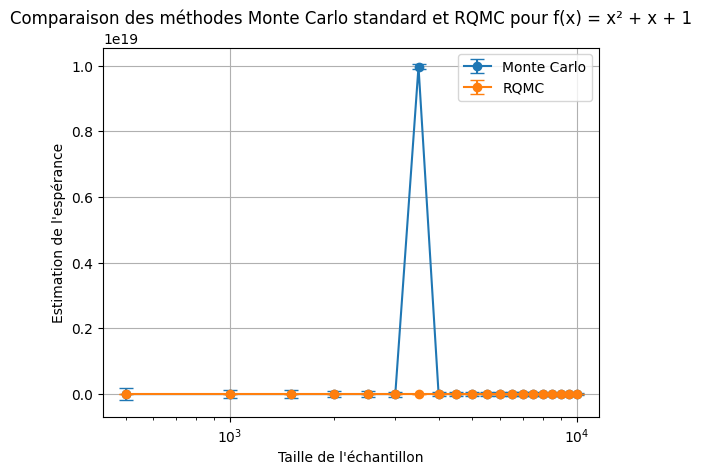

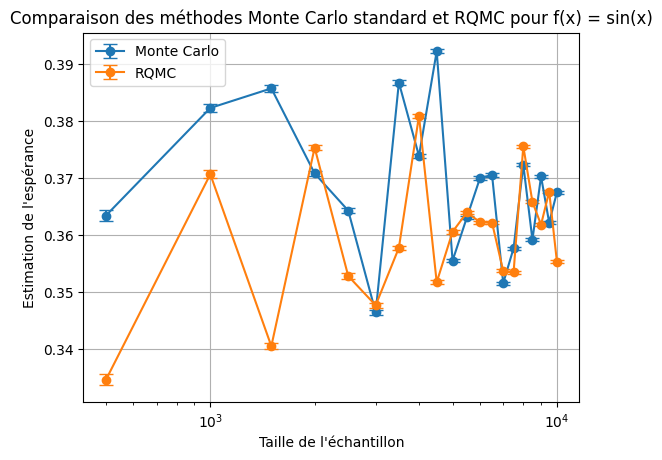

In [205]:
for f in [f1,f2,f3,f4]:
    max_n = 10000
    # Nombre de points à évaluer
    num_points = 20
# Fonctions à évaluer avec leurs noms correspondants
functions = [(f1, ' f(x) = x'), (f2, 'f(x) = exp(-x²)'), (f3, 'f(x) = x² + x + 1'), (f4, 'f(x) = sin(x)')]

# Calcul et tracé des résultats pour chaque fonction
for f, name in functions:
    # Tableaux pour stocker les résultats
    mc_estimates = np.zeros(num_points)
    rqmc_estimates = np.zeros(num_points)
    sample_sizes = np.zeros(num_points)

    # Calcul des estimations pour différentes tailles d'échantillons
    for i in range(num_points):
        n = (i + 1) * (max_n // num_points)
        sample_sizes[i] = n
        mc_estimates[i] = monte_carlo_estimate(f, n, alpha, beta, gamma, delta)
        rqmc_estimates[i] = rqmc_estimate(f, n, alpha, beta, gamma, delta)

    # Calcul des intervalles de confiance
    mc_std_err = np.std(mc_estimates) / np.sqrt(sample_sizes)
    rqmc_std_err = np.std(rqmc_estimates) / np.sqrt(sample_sizes)
    mc_conf_interval = 1.96 * mc_std_err  # Intervalle de confiance à 95%
    rqmc_conf_interval = 1.96 * rqmc_std_err  # Intervalle de confiance à 95%

    # Tracé des résultats
    plt.errorbar(sample_sizes, mc_estimates, yerr=mc_conf_interval, label='Monte Carlo', fmt='o-', capsize=5)
    plt.errorbar(sample_sizes, rqmc_estimates, yerr=rqmc_conf_interval, label='RQMC', fmt='o-', capsize=5)
    plt.xscale('log')
    plt.xlabel('Taille de l\'échantillon')
    plt.ylabel('Estimation de l\'espérance')
    plt.title('Comparaison des méthodes Monte Carlo standard et RQMC pour ' + name)
    plt.legend()
    plt.grid(True)
    plt.show()